# Databricks Data Governance & Lineage Monitor

## Overview

This notebook provides a **comprehensive data governance assessment** by analyzing Unity Catalog tables, data lineage, ownership, access patterns, storage utilization, and data quality. The output includes detailed reports on table inventory, stale tables, missing documentation, ownership gaps, and actionable governance recommendations.

**✨ Enterprise-grade data governance with table inventory, lineage tracking, ownership analysis, stale table detection, and data quality assessment.**

---

## Features

### Table Inventory
* **Complete Catalog Scan**: All catalogs, schemas, tables, and views
* **Table Metadata**: Owner, size, row count, file format, partitions
* **Storage Analysis**: Total storage by catalog/schema/table
* **Table Types**: Managed vs external tables, views, materialized views
* **Creation & Modification**: Timestamps for all tables

### Data Lineage
* **Upstream Dependencies**: Source tables for each table
* **Downstream Dependencies**: Tables consuming each table
* **Lineage Depth**: Number of hops in lineage chain
* **Orphaned Tables**: Tables with no lineage
* **Popular Tables**: Most referenced tables

### Ownership & Governance
* **Owner Tracking**: Table owners from Unity Catalog
* **Missing Owners**: Tables without assigned owners
* **Owner Distribution**: Tables per owner
* **Orphaned Tables**: Tables with inactive/missing owners
* **Ownership Gaps**: Critical tables without clear ownership

### Access Patterns
* **Query Frequency**: Tables queried in last 30/60/90 days
* **Last Access Time**: Most recent query per table
* **Frequent Users**: Top users accessing each table
* **Access Trends**: Query patterns over time
* **Unused Tables**: Tables never queried

### Stale Table Detection
* **No Recent Access**: Tables not queried in 90+ days
* **No Recent Updates**: Tables not modified in 180+ days
* **Zero Rows**: Empty tables
* **Cleanup Candidates**: Tables eligible for archival/deletion

### Data Quality
* **Missing Descriptions**: Tables without comments
* **Missing Tags**: Tables without governance tags
* **Schema Issues**: Tables with many columns, complex types
* **Naming Conventions**: Tables with non-standard names

### Recommendations
* **Stale Table Cleanup**: Tables to archive or delete
* **Ownership Assignment**: Tables needing owners
* **Documentation Needs**: Tables missing descriptions/tags
* **Access Control**: Over-permissioned tables

---

## Version Control

| Version | Date | Author | Changes |
|---------|------|--------|---------|  
| 1.0.0 | 2026-02-16 | Assistant | Comprehensive data governance and lineage monitoring system with complete Unity Catalog coverage. Features include: table inventory across all catalogs/schemas/tables with metadata (owner, size, row count, file format, partitions, creation/modification timestamps), data lineage analysis (upstream/downstream dependencies, lineage depth, orphaned tables, popular tables), ownership tracking and gap identification (missing owners, inactive owners, owner distribution), access pattern analysis via system.access.audit (query frequency, last access time, frequent users, unused tables), stale table detection (no access in 90+ days, no updates in 180+ days, zero-row tables, cleanup candidates), data quality assessment (missing descriptions, missing tags, schema complexity, naming convention violations), storage utilization analysis (total storage by catalog/schema, largest tables, growth trends), governance recommendations (stale table cleanup, ownership assignment, documentation needs, access control review), multiple export formats (Delta table with historical tracking, Excel multi-sheet workbook), interactive visualizations (storage distribution, access patterns, stale tables, ownership distribution), job mode support with automatic configuration, serverless compute optimization, parallel processing for large catalogs, retry logic, progress tracking, and comprehensive error handling. |

---

## Configuration

### Catalogs to Scan:
* `CATALOGS_TO_SCAN = ['main', 'hive_metastore']` - List of catalogs to analyze
* `SCAN_ALL_CATALOGS = True` - Scan all accessible catalogs (overrides list)

### Analysis Thresholds:
* `STALE_ACCESS_DAYS = 90` - Days without access to flag as stale
* `STALE_UPDATE_DAYS = 180` - Days without updates to flag as stale
* `LARGE_TABLE_GB = 100` - Size threshold for large table flagging
* `MIN_QUERIES_FOR_ANALYSIS = 5` - Minimum queries for trend analysis

### Performance Settings:
* `MAX_TABLES_PER_SCHEMA = 999` - Maximum tables per schema (999 = all)
* `MAX_WORKERS = 10` - Parallel threads for API calls
* `MAX_RETRIES = 3` - Retries for failed operations

### Export Settings:
* `EXPORT_PATH = '/dbfs/tmp/governance_export'` - Export directory
* `ENABLE_EXCEL_EXPORT = True` - Excel workbook generation
* `ENABLE_DELTA_EXPORT = True` - Delta table for historical tracking
* `ENABLE_VISUALIZATIONS = True` - Generate charts
* `DELTA_TABLE_NAME = 'main.default.governance_history'` - Delta table name

---

## Usage

### Interactive Mode
1. Configure catalogs to scan in Cell 3
2. Run all cells to analyze data governance
3. Review table inventory and stale tables
4. View lineage and access patterns
5. Download Excel report from export path

### Job Mode
1. Schedule as a Databricks job (weekly recommended)
2. Automatically scans all catalogs
3. Exports to Delta table for trend tracking
4. Returns JSON summary for orchestration

---

## Data Sources

| Data Source | Purpose |
|-------------|----------|
| Unity Catalog API | Table inventory, metadata, ownership |
| `system.access.audit` | Table access patterns, query frequency |
| `system.information_schema.tables` | Table statistics, storage size |
| Lineage API | Upstream/downstream dependencies |

---

## Key Features

✓ **Complete Table Inventory**: All Unity Catalog tables  
✓ **Data Lineage Tracking**: Upstream/downstream dependencies  
✓ **Ownership Analysis**: Owner tracking and gap identification  
✓ **Access Pattern Analysis**: Query frequency and last access  
✓ **Stale Table Detection**: 90-day access threshold  
✓ **Storage Analysis**: Size tracking and growth trends  
✓ **Data Quality Assessment**: Missing docs, tags, schema issues  
✓ **Governance Recommendations**: Prioritized action items  
✓ **System Table Queries**: Leverages system.access.audit  
✓ **Multiple Export Formats**: Excel and Delta table  
✓ **Interactive Visualizations**: Charts and distributions  
✓ **Job Mode Support**: Automated scheduled execution  
✓ **Serverless Optimized**: Compute-aware optimizations  
✓ **Parallel Processing**: Fast catalog scanning  
✓ **Historical Tracking**: Delta table with append mode

In [0]:
%pip install openpyxl --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# ============================================================================
# IMPORTS
# ============================================================================

# Standard library
import time
import os
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

# Third-party
import pandas as pd
import pytz

# Databricks SDK
from databricks.sdk import WorkspaceClient
from databricks.sdk.errors import NotFound, PermissionDenied

# PySpark
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, TimestampType, DoubleType

# ============================================================================
# JOB MODE DETECTION (MUST BE FIRST)
# ============================================================================

try:
    dbutils.notebook.entry_point.getDbutils().notebook().getContext().currentRunId().isDefined()
    is_job_mode = True
except:
    is_job_mode = False

# ============================================================================
# SERVERLESS DETECTION
# ============================================================================

try:
    test_df = spark.range(1)
    test_df.cache()
    test_df.count()
    test_df.unpersist()
    is_serverless = False
except Exception as e:
    if 'PERSIST' in str(e).upper() or 'CACHE' in str(e).upper():
        is_serverless = True
    else:
        is_serverless = False

# ============================================================================
# TIMEZONE CONFIGURATION
# ============================================================================

TIMEZONE = 'America/New_York'
eastern = pytz.timezone(TIMEZONE)

# ============================================================================
# LOGGING FUNCTION
# ============================================================================

def log(message):
    """Print messages (always in interactive, selectively in job mode)"""
    print(message)

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Catalogs to scan
SCAN_ALL_CATALOGS = True  # If True, scans all accessible catalogs
CATALOGS_TO_SCAN = ['main', 'hive_metastore']  # Used if SCAN_ALL_CATALOGS = False

# Analysis thresholds
STALE_ACCESS_DAYS = 90  # Days without access to flag as stale
STALE_UPDATE_DAYS = 180  # Days without updates to flag as stale
LARGE_TABLE_GB = 100  # Size threshold for large table flagging
MIN_QUERIES_FOR_ANALYSIS = 5  # Minimum queries for trend analysis

# Table limits
MAX_TABLES_PER_SCHEMA = 999  # Maximum tables per schema (999 = all)

# Performance settings
MAX_WORKERS = 10
MAX_RETRIES = 3
RETRY_DELAY = 2

# Export settings (disabled in interactive mode, enabled in job mode)
EXPORT_PATH = '/dbfs/tmp/governance_export'
if is_job_mode:
    ENABLE_EXCEL_EXPORT = True
    ENABLE_DELTA_EXPORT = True
    ENABLE_JSON_EXPORT = True
    log("🤖 Job mode: Exports ENABLED")
else:
    ENABLE_EXCEL_EXPORT = False
    ENABLE_DELTA_EXPORT = False
    ENABLE_JSON_EXPORT = False
    log("💻 Interactive mode: Exports DISABLED")

ENABLE_VISUALIZATIONS = True

# Delta table configuration
DELTA_TABLE_NAME = 'main.default.governance_history'

# ============================================================================
# EXECUTION STATISTICS
# ============================================================================

execution_stats = {
    'start_time': time.time(),
    'api_calls': 0,
    'api_failures': 0,
    'catalogs_scanned': 0,
    'schemas_scanned': 0,
    'tables_scanned': 0
}

# ============================================================================
# INITIALIZE SDK CLIENT
# ============================================================================

wc = WorkspaceClient()

log("\n" + "="*60)
log("DATA GOVERNANCE & LINEAGE MONITOR")
log("="*60)
log(f"Execution mode: {'JOB' if is_job_mode else 'INTERACTIVE'}")
log(f"Compute type: {'SERVERLESS' if is_serverless else 'TRADITIONAL'}")
log(f"Timezone: {TIMEZONE}")
log(f"Stale thresholds: Access={STALE_ACCESS_DAYS}d, Update={STALE_UPDATE_DAYS}d")
log(f"Excel export: {'ENABLED' if ENABLE_EXCEL_EXPORT else 'DISABLED'}")
log(f"Delta export: {'ENABLED' if ENABLE_DELTA_EXPORT else 'DISABLED'}")
log(f"JSON export: {'ENABLED' if ENABLE_JSON_EXPORT else 'DISABLED'}")
log("="*60)

💻 Interactive mode: Exports DISABLED

DATA GOVERNANCE & LINEAGE MONITOR
Execution mode: INTERACTIVE
Compute type: SERVERLESS
Timezone: America/New_York
Stale thresholds: Access=90d, Update=180d
Excel export: DISABLED
Delta export: DISABLED
JSON export: DISABLED


In [0]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def log_execution_time(cell_name, start_time):
    """Log execution time for a cell"""
    elapsed = time.time() - start_time
    log(f"⏱️  {cell_name} completed in {elapsed:.2f} seconds")

def validate_dataframe_exists(df_name, df):
    """Validate that a DataFrame exists and has data"""
    if df is None:
        log(f"⚠️  Warning: {df_name} is None")
        return False
    try:
        count = df.count()
        if count == 0:
            log(f"⚠️  Warning: {df_name} is empty (0 rows)")
            return False
        return True
    except Exception as e:
        log(f"⚠️  Warning: Error checking {df_name}: {str(e)}")
        return False

def format_bytes(bytes_val):
    """Format bytes in human-readable format"""
    if bytes_val is None:
        return 'N/A'
    
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if bytes_val < 1024.0:
            return f"{bytes_val:.2f} {unit}"
        bytes_val /= 1024.0
    return f"{bytes_val:.2f} PB"

log("✓ Helper functions loaded")

✓ Helper functions loaded


In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("FETCHING UNITY CATALOG INVENTORY")
log("="*60)

try:
    # Get catalogs to scan
    if SCAN_ALL_CATALOGS:
        log("Fetching all accessible catalogs...")
        catalogs = list(wc.catalogs.list())
        catalog_names = [c.name for c in catalogs]
    else:
        catalog_names = CATALOGS_TO_SCAN
    
    log(f"✓ Scanning {len(catalog_names)} catalogs: {', '.join(catalog_names)}")
    
    # Fetch all tables across catalogs
    all_tables = []
    
    for catalog_name in catalog_names:
        try:
            log(f"\nScanning catalog: {catalog_name}")
            
            # Get schemas in catalog
            schemas = list(wc.schemas.list(catalog_name=catalog_name))
            log(f"  Found {len(schemas)} schemas")
            
            execution_stats['schemas_scanned'] += len(schemas)
            
            for schema in schemas:
                try:
                    # Get tables in schema
                    tables = list(wc.tables.list(
                        catalog_name=catalog_name,
                        schema_name=schema.name
                    ))
                    
                    if MAX_TABLES_PER_SCHEMA < 999:
                        tables = tables[:MAX_TABLES_PER_SCHEMA]
                    
                    for table in tables:
                        all_tables.append({
                            'catalog_name': catalog_name,
                            'schema_name': schema.name,
                            'table_name': table.name,
                            'full_name': f"{catalog_name}.{schema.name}.{table.name}",
                            'table_type': table.table_type.value if table.table_type else 'UNKNOWN',
                            'data_source_format': table.data_source_format.value if table.data_source_format else None,
                            'owner': table.owner,
                            'comment': table.comment,
                            'created_at': datetime.fromtimestamp(table.created_at / 1000, tz=eastern) if table.created_at else None,
                            'updated_at': datetime.fromtimestamp(table.updated_at / 1000, tz=eastern) if table.updated_at else None,
                            'storage_location': table.storage_location,
                            'column_count': len(table.columns) if table.columns else 0
                        })
                    
                    execution_stats['tables_scanned'] += len(tables)
                    
                except Exception as e:
                    log(f"    ⚠️  Error scanning schema {schema.name}: {str(e)[:100]}")
                    continue
            
            execution_stats['catalogs_scanned'] += 1
            
        except Exception as e:
            log(f"  ✗ Error scanning catalog {catalog_name}: {str(e)[:100]}")
            continue
    
    # Create DataFrame
    if all_tables:
        tables_df = spark.createDataFrame(all_tables)
        
        log(f"\n✓ Inventory complete:")
        log(f"  Catalogs: {execution_stats['catalogs_scanned']}")
        log(f"  Schemas: {execution_stats['schemas_scanned']}")
        log(f"  Tables: {len(all_tables):,}")
        log(f"  Table types: {tables_df.select('table_type').distinct().count()}")
        log(f"  Tables with owners: {tables_df.filter(F.col('owner').isNotNull()).count()}")
        log(f"  Tables with descriptions: {tables_df.filter(F.col('comment').isNotNull()).count()}")
    else:
        log("⚠️  No tables found")
        tables_df = None
        
except Exception as e:
    log(f"✗ Error fetching inventory: {str(e)}")
    tables_df = None

log_execution_time("Fetch Inventory", cell_start_time)


FETCHING UNITY CATALOG INVENTORY
Fetching all accessible catalogs...
✓ Scanning 17 catalogs: __databricks_internal, aterio_io_us_population_forecast_by_zipcode_2010_2035, d_discovery_finance_uc, main, rai_dev_uc, rai_dev_uc_brightidea, rai_prod_uc, rai_prod_uc_gm, rai_prod_uc_sfmd, rai_prod_uc_tradepmt, rai_qa_uc, rai_qa_uc_gm, rai_qa_uc_sfmd, rai_qa_uc_tradepmt, samples, system, test

Scanning catalog: __databricks_internal
  Found 62 schemas

Scanning catalog: aterio_io_us_population_forecast_by_zipcode_2010_2035
  Found 2 schemas

Scanning catalog: d_discovery_finance_uc
  Found 3 schemas

Scanning catalog: main
  Found 3 schemas

Scanning catalog: rai_dev_uc
  Found 475 schemas

Scanning catalog: rai_dev_uc_brightidea
  Found 3 schemas

Scanning catalog: rai_prod_uc
  Found 321 schemas

Scanning catalog: rai_prod_uc_gm
  Found 7 schemas

Scanning catalog: rai_prod_uc_sfmd
  Found 6 schemas

Scanning catalog: rai_prod_uc_tradepmt
  Found 10 schemas

Scanning catalog: rai_qa_uc
  Fo

In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("ANALYZING TABLE ACCESS PATTERNS")
log("="*60)

if tables_df is not None:
    try:
        # Query audit logs for table access
        log(f"Querying system.access.audit for table access (last {STALE_ACCESS_DAYS} days)...")
        
        start_date = (datetime.now(eastern) - timedelta(days=STALE_ACCESS_DAYS)).strftime('%Y-%m-%d')
        
        access_query = f"""
        SELECT 
            request_params.table_full_name as table_full_name,
            user_identity.email as user_name,
            DATE(event_date) as access_date,
            COUNT(*) as query_count
        FROM system.access.audit
        WHERE event_date >= '{start_date}'
            AND action_name IN ('getTable', 'readTable', 'executeQuery')
            AND request_params.table_full_name IS NOT NULL
        GROUP BY request_params.table_full_name, user_identity.email, DATE(event_date)
        """
        
        access_df = spark.sql(access_query)
        
        log(f"✓ Fetched {access_df.count():,} access records")
        
        # Calculate access metrics per table
        table_access = access_df.groupBy('table_full_name').agg(
            F.sum('query_count').alias('total_queries'),
            F.countDistinct('user_name').alias('unique_users'),
            F.countDistinct('access_date').alias('days_accessed'),
            F.max('access_date').alias('last_access_date')
        )
        
        log(f"✓ Analyzed access for {table_access.count()} tables")
        
        # Join with table inventory
        tables_with_access = tables_df.join(
            table_access,
            tables_df.full_name == table_access.table_full_name,
            'left'
        ).drop('table_full_name')
        
        # Calculate days since last access
        tables_with_access = tables_with_access.withColumn(
            'days_since_access',
            F.datediff(F.lit(datetime.now(eastern).date()), F.col('last_access_date'))
        )
        
        # Fill nulls for tables with no access
        tables_with_access = tables_with_access.fillna({
            'total_queries': 0,
            'unique_users': 0,
            'days_accessed': 0
        })
        
        log(f"\n📊 Access Summary:")
        log(f"  Tables with access: {tables_with_access.filter(F.col('total_queries') > 0).count()}")
        log(f"  Tables never accessed: {tables_with_access.filter(F.col('total_queries') == 0).count()}")
        
    except Exception as e:
        log(f"✗ Error querying access patterns: {str(e)}")
        log("  Note: Requires system.access.audit access")
        tables_with_access = tables_df
else:
    log("⚠️  Skipping access analysis (no tables)")
    tables_with_access = None

log_execution_time("Access Analysis", cell_start_time)


ANALYZING TABLE ACCESS PATTERNS
Querying system.access.audit for table access (last 90 days)...
✓ Fetched 0 access records
✓ Analyzed access for 0 tables

📊 Access Summary:
  Tables with access: 0
  Tables never accessed: 77944
⏱️  Access Analysis completed in 108.19 seconds


In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("IDENTIFYING STALE AND PROBLEMATIC TABLES")
log("="*60)

if tables_with_access is not None:
    try:
        # Stale tables (no access in STALE_ACCESS_DAYS)
        stale_access = tables_with_access.filter(
            (F.col('days_since_access') > STALE_ACCESS_DAYS) | 
            (F.col('last_access_date').isNull())
        )
        stale_access_count = stale_access.count()
        
        # Tables with no owner
        no_owner = tables_with_access.filter(F.col('owner').isNull())
        no_owner_count = no_owner.count()
        
        # Tables with no description
        no_description = tables_with_access.filter(
            (F.col('comment').isNull()) | (F.col('comment') == '')
        )
        no_description_count = no_description.count()
        
        # Tables never accessed
        never_accessed = tables_with_access.filter(F.col('total_queries') == 0)
        never_accessed_count = never_accessed.count()
        
        log(f"\n🔍 Governance Issues Found:")
        log(f"  🗑️  Stale tables (no access >{STALE_ACCESS_DAYS}d): {stale_access_count}")
        log(f"  👤 Tables without owner: {no_owner_count}")
        log(f"  📝 Tables without description: {no_description_count}")
        log(f"  🚫 Tables never accessed: {never_accessed_count}")
        
        # Top stale tables by size (cleanup candidates)
        if stale_access_count > 0:
            log(f"\n  Top 10 stale tables (cleanup candidates):")
            top_stale = stale_access.orderBy(F.desc('days_since_access')).limit(10)
            for row in top_stale.collect():
                days = row.days_since_access if row.days_since_access else 'Never'
                log(f"    - {row.full_name}: {days} days since access")
        
        # Tables with missing governance metadata
        governance_issues = tables_with_access.filter(
            (F.col('owner').isNull()) | 
            (F.col('comment').isNull()) |
            (F.col('comment') == '')
        )
        governance_issues_count = governance_issues.count()
        
        log(f"\n⚠️  Tables with governance issues: {governance_issues_count}")
        
    except Exception as e:
        log(f"✗ Error identifying issues: {str(e)}")
        stale_access = None
        no_owner = None
        governance_issues = None
else:
    log("⚠️  Skipping issue identification (no data)")
    stale_access = None
    no_owner = None
    governance_issues = None

log_execution_time("Identify Issues", cell_start_time)


IDENTIFYING STALE AND PROBLEMATIC TABLES

🔍 Governance Issues Found:
  🗑️  Stale tables (no access >90d): 77944
  👤 Tables without owner: 0
  📝 Tables without description: 76691
  🚫 Tables never accessed: 77944

  Top 10 stale tables (cleanup candidates):
    - rai_dev_uc.d_core_ops.temp_build_la2_arch_class_catalog: Never days since access
    - rai_dev_uc.d_core_ops.temp_build_mdaomigt_b_cleaning_image: Never days since access
    - rai_dev_uc.d_core_ops.temp_build_cro_clinical_raw_test: Never days since access
    - rai_dev_uc.d_core_ops.temp_build_ibb_converted_ing_names: Never days since access
    - rai_dev_uc.d_core_ops.temp_build_mdaigt_b_safety_trigger_form: Never days since access
    - rai_dev_uc.d_core_ops.temp_build_cfg_fs_type: Never days since access
    - rai_dev_uc.d_core_ops.temp_build_ignit_tb_b_iws_action_classification: Never days since access
    - rai_dev_uc.d_core_ops.temp_build_mdaomigt_b_breakdown_type: Never days since access
    - rai_dev_uc.d_core_ops.temp

In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("GENERATING GOVERNANCE RECOMMENDATIONS")
log("="*60)

recommendations = []

if tables_with_access is not None:
    # Critical: Tables without owners
    if no_owner_count > 0:
        recommendations.append({
            'priority': 'HIGH',
            'category': 'Ownership',
            'issue': f'{no_owner_count} tables without assigned owners',
            'impact': 'Unclear accountability, governance gap',
            'recommendation': 'Assign owners to all tables using ALTER TABLE SET OWNER',
            'affected_count': no_owner_count
        })
    
    # High: Stale tables
    if stale_access_count > 0:
        recommendations.append({
            'priority': 'MEDIUM',
            'category': 'Data Lifecycle',
            'issue': f'{stale_access_count} stale tables (no access >{STALE_ACCESS_DAYS} days)',
            'impact': 'Wasted storage, unclear data relevance',
            'recommendation': f'Review and archive/delete {stale_access_count} stale tables',
            'affected_count': stale_access_count
        })
    
    # Medium: Missing documentation
    if no_description_count > 0:
        recommendations.append({
            'priority': 'MEDIUM',
            'category': 'Documentation',
            'issue': f'{no_description_count} tables without descriptions',
            'impact': 'Poor discoverability, unclear purpose',
            'recommendation': 'Add COMMENT descriptions to all tables',
            'affected_count': no_description_count
        })
    
    # Low: Never accessed tables
    if never_accessed_count > 0:
        recommendations.append({
            'priority': 'LOW',
            'category': 'Data Lifecycle',
            'issue': f'{never_accessed_count} tables never accessed',
            'impact': 'Potentially unused data, storage waste',
            'recommendation': 'Verify if tables are needed, consider deletion',
            'affected_count': never_accessed_count
        })
    
    # Create recommendations DataFrame
    if recommendations:
        recommendations_df = spark.createDataFrame(recommendations)
        
        log(f"\n💡 Generated {len(recommendations)} recommendations:")
        for rec in recommendations:
            log(f"  {rec['priority']}: {rec['issue']}")
            log(f"    → {rec['recommendation']}")
    else:
        recommendations_df = None
        log("\n✅ No recommendations - governance looks good!")
else:
    log("⚠️  Skipping recommendations (no data)")
    recommendations_df = None

log_execution_time("Generate Recommendations", cell_start_time)


GENERATING GOVERNANCE RECOMMENDATIONS

💡 Generated 3 recommendations:
  MEDIUM: 77944 stale tables (no access >90 days)
    → Review and archive/delete 77944 stale tables
  MEDIUM: 76691 tables without descriptions
    → Add COMMENT descriptions to all tables
  LOW: 77944 tables never accessed
    → Verify if tables are needed, consider deletion
⏱️  Generate Recommendations completed in 0.08 seconds



VISUALIZATIONS


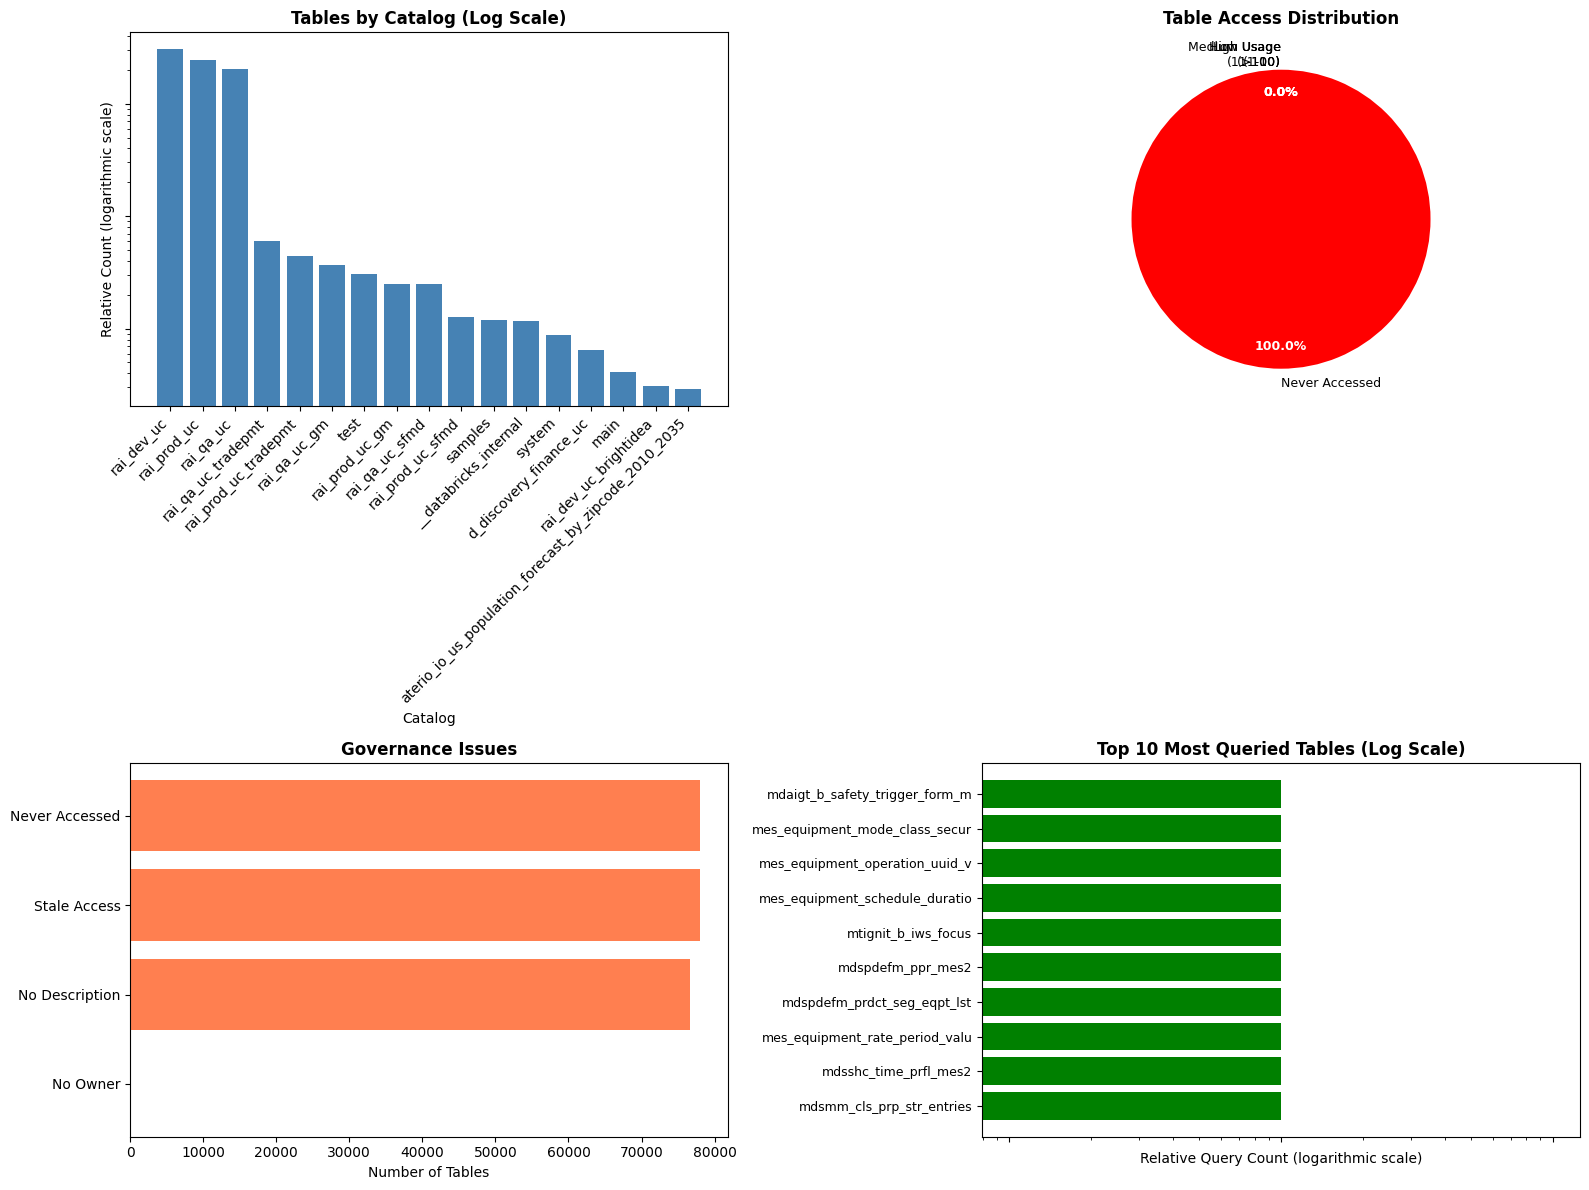

✓ Visualizations generated
⏱️  Visualizations completed in 169.36 seconds


In [0]:
cell_start_time = time.time()

if not is_job_mode and ENABLE_VISUALIZATIONS and tables_with_access is not None:
    log("\n" + "="*60)
    log("VISUALIZATIONS")
    log("="*60)
    
    import matplotlib.pyplot as plt
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Chart 1: Tables by Catalog (with logarithmic scale)
    ax1 = axes[0, 0]
    catalog_dist = tables_with_access.groupBy('catalog_name').count().toPandas().sort_values('count', ascending=False)
    ax1.bar(catalog_dist['catalog_name'], catalog_dist['count'], color='steelblue')
    ax1.set_title('Tables by Catalog (Log Scale)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Catalog')
    ax1.set_ylabel('Relative Count (logarithmic scale)')
    ax1.set_yscale('log')  # Use logarithmic scale for y-axis
    ax1.set_yticklabels([])  # Hide numeric tick labels
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Chart 2: Table Access Distribution
    ax2 = axes[0, 1]
    access_categories = [
        ('Never Accessed', tables_with_access.filter(F.col('total_queries') == 0).count()),
        ('Low Usage\n(1-10)', tables_with_access.filter((F.col('total_queries') >= 1) & (F.col('total_queries') <= 10)).count()),
        ('Medium Usage\n(11-100)', tables_with_access.filter((F.col('total_queries') > 10) & (F.col('total_queries') <= 100)).count()),
        ('High Usage\n(>100)', tables_with_access.filter(F.col('total_queries') > 100).count())
    ]
    labels = [cat[0] for cat in access_categories]
    values = [cat[1] for cat in access_categories]
    colors_pie = ['red', 'orange', 'lightblue', 'green']
    
    # Create pie chart with better label positioning
    wedges, texts, autotexts = ax2.pie(values, labels=labels, autopct='%1.1f%%', 
                                        colors=colors_pie, startangle=90,
                                        pctdistance=0.85, labeldistance=1.1)
    
    # Adjust font sizes
    for text in texts:
        text.set_fontsize(9)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    
    ax2.set_title('Table Access Distribution', fontsize=12, fontweight='bold')
    
    # Chart 3: Governance Issues
    ax3 = axes[1, 0]
    issues = ['No Owner', 'No Description', 'Stale Access', 'Never Accessed']
    counts = [
        no_owner_count if 'no_owner_count' in dir() else 0,
        no_description_count if 'no_description_count' in dir() else 0,
        stale_access_count if 'stale_access_count' in dir() else 0,
        never_accessed_count if 'never_accessed_count' in dir() else 0
    ]
    ax3.barh(issues, counts, color='coral')
    ax3.set_title('Governance Issues', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Number of Tables')
    
    # Chart 4: Top 10 Most Queried Tables (with logarithmic scale)
    ax4 = axes[1, 1]
    top_tables = tables_with_access.orderBy(F.desc('total_queries')).limit(10).toPandas()
    if len(top_tables) > 0:
        # Ensure no zero values for log scale
        top_tables['total_queries'] = top_tables['total_queries'].apply(lambda x: max(x, 0.1))
        ax4.barh(range(len(top_tables)), top_tables['total_queries'], color='green')
        ax4.set_yticks(range(len(top_tables)))
        ax4.set_yticklabels([name.split('.')[-1][:30] for name in top_tables['full_name']], fontsize=9)
        ax4.set_title('Top 10 Most Queried Tables (Log Scale)', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Relative Query Count (logarithmic scale)')
        ax4.set_xscale('log')  # Use logarithmic scale for x-axis
        ax4.set_xticklabels([])  # Hide numeric tick labels
        ax4.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    log("✓ Visualizations generated")
else:
    if is_job_mode:
        log("ℹ️  Visualizations skipped (job mode)")
    else:
        log("ℹ️  Visualizations skipped (no data or disabled)")

log_execution_time("Visualizations", cell_start_time)

In [0]:
cell_start_time = time.time()

if ENABLE_EXCEL_EXPORT and tables_with_access is not None:
    log("\n" + "="*60)
    log("EXPORTING TO EXCEL")
    log("="*60)
    
    try:
        # Create export directory
        if is_serverless:
            import tempfile
            temp_dir = tempfile.mkdtemp()
            export_path = temp_dir
        else:
            export_path = EXPORT_PATH
            os.makedirs(export_path, exist_ok=True)
        
        timestamp = datetime.now(eastern).strftime('%Y%m%d_%H%M%S')
        excel_path = f"{export_path}/governance_report_{timestamp}.xlsx"
        
        log(f"Creating Excel workbook: {excel_path}")
        
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            # Sheet 1: Table Inventory
            tables_with_access.orderBy('catalog_name', 'schema_name', 'table_name').toPandas().to_excel(writer, sheet_name='Table Inventory', index=False)
            
            # Sheet 2: Stale Tables
            if stale_access is not None and stale_access.count() > 0:
                stale_access.orderBy(F.desc('days_since_access')).toPandas().to_excel(writer, sheet_name='Stale Tables', index=False)
            
            # Sheet 3: Tables Without Owners
            if no_owner is not None and no_owner.count() > 0:
                no_owner.toPandas().to_excel(writer, sheet_name='No Owner', index=False)
            
            # Sheet 4: Governance Issues
            if governance_issues is not None and governance_issues.count() > 0:
                governance_issues.toPandas().to_excel(writer, sheet_name='Governance Issues', index=False)
            
            # Sheet 5: Recommendations
            if recommendations_df is not None:
                recommendations_df.toPandas().to_excel(writer, sheet_name='Recommendations', index=False)
            
            # Sheet 6: Summary
            summary_data = {
                'Metric': [
                    'Total Tables',
                    'Catalogs Scanned',
                    'Schemas Scanned',
                    'Tables with Owners',
                    'Tables with Descriptions',
                    'Stale Tables',
                    'Never Accessed Tables',
                    'Governance Issues',
                    'Analysis Date'
                ],
                'Value': [
                    tables_with_access.count(),
                    execution_stats['catalogs_scanned'],
                    execution_stats['schemas_scanned'],
                    tables_with_access.filter(F.col('owner').isNotNull()).count(),
                    tables_with_access.filter(F.col('comment').isNotNull()).count(),
                    stale_access_count if 'stale_access_count' in dir() else 0,
                    never_accessed_count if 'never_accessed_count' in dir() else 0,
                    governance_issues_count if 'governance_issues_count' in dir() else 0,
                    datetime.now(eastern).strftime('%Y-%m-%d %H:%M:%S')
                ]
            }
            pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary', index=False)
        
        # Apply formatting
        from openpyxl import load_workbook
        from openpyxl.styles import Font, PatternFill, Alignment
        
        wb = load_workbook(excel_path)
        for sheet_name in wb.sheetnames:
            ws = wb[sheet_name]
            
            # Format header row
            for cell in ws[1]:
                cell.font = Font(bold=True, color='FFFFFF')
                cell.fill = PatternFill(start_color='366092', end_color='366092', fill_type='solid')
                cell.alignment = Alignment(horizontal='center')
            
            # Auto-adjust column widths
            for column in ws.columns:
                max_length = 0
                column_letter = column[0].column_letter
                for cell in column:
                    if cell.value:
                        max_length = max(max_length, len(str(cell.value)))
                ws.column_dimensions[column_letter].width = min(max_length + 2, 50)
        
        wb.save(excel_path)
        
        log(f"✓ Excel workbook created: {excel_path}")
        log(f"  Sheets: {len(wb.sheetnames)}")
        
    except Exception as e:
        log(f"✗ Excel export failed: {str(e)}")
else:
    log("ℹ️  Excel export skipped")

log_execution_time("Excel Export", cell_start_time)

ℹ️  Excel export skipped
⏱️  Excel Export completed in 0.00 seconds


In [0]:
cell_start_time = time.time()

if ENABLE_DELTA_EXPORT and tables_with_access is not None:
    log("\n" + "="*60)
    log("EXPORTING TO DELTA TABLE")
    log("="*60)
    
    try:
        # Add audit metadata
        tables_export = tables_with_access.withColumn('audit_timestamp', F.current_timestamp())
        tables_export = tables_export.withColumn('lookback_days', F.lit(STALE_ACCESS_DAYS))
        
        # Write to Delta table (append mode)
        tables_export.write \
            .format('delta') \
            .mode('append') \
            .option('mergeSchema', 'true') \
            .saveAsTable(DELTA_TABLE_NAME)
        
        log(f"✓ Delta table updated: {DELTA_TABLE_NAME}")
        log(f"  Mode: append (historical retention)")
        log(f"  Rows added: {tables_with_access.count()}")
        
    except Exception as e:
        log(f"✗ Delta export failed: {str(e)}")
else:
    log("ℹ️  Delta export skipped")

log_execution_time("Delta Export", cell_start_time)

ℹ️  Delta export skipped
⏱️  Delta Export completed in 0.00 seconds


In [0]:
# ============================================================================
# EXECUTION SUMMARY
# ============================================================================

execution_time = time.time() - execution_stats['start_time']

log("\n" + "="*60)
log("EXECUTION SUMMARY")
log("="*60)

log(f"\n⏱️  Total execution time: {execution_time:.2f} seconds")

log(f"\n📊 Statistics:")
log(f"  Catalogs scanned: {execution_stats['catalogs_scanned']}")
log(f"  Schemas scanned: {execution_stats['schemas_scanned']}")
log(f"  Tables scanned: {execution_stats['tables_scanned']:,}")
log(f"  API calls: {execution_stats['api_calls']}")
log(f"  API failures: {execution_stats['api_failures']}")

if tables_with_access is not None:
    log(f"\n🗄️  Governance Summary:")
    log(f"  Total tables: {tables_with_access.count():,}")
    log(f"  Tables with owners: {tables_with_access.filter(F.col('owner').isNotNull()).count()}")
    log(f"  Tables with descriptions: {tables_with_access.filter(F.col('comment').isNotNull()).count()}")
    log(f"  Stale tables: {stale_access_count if 'stale_access_count' in dir() else 0}")
    log(f"  Never accessed: {never_accessed_count if 'never_accessed_count' in dir() else 0}")
    log(f"  Governance issues: {governance_issues_count if 'governance_issues_count' in dir() else 0}")

if recommendations_df is not None:
    log(f"\n💡 Recommendations: {recommendations_df.count()}")

log("\n" + "="*60)
log("✓ DATA GOVERNANCE & LINEAGE ANALYSIS COMPLETE")
log("="*60)

# Return JSON summary for job mode
if is_job_mode:
    import json
    summary = {
        'status': 'success',
        'execution_time_seconds': execution_time,
        'tables_scanned': execution_stats['tables_scanned'],
        'catalogs_scanned': execution_stats['catalogs_scanned'],
        'stale_tables': stale_access_count if 'stale_access_count' in dir() else 0,
        'governance_issues': governance_issues_count if 'governance_issues_count' in dir() else 0,
        'recommendations': recommendations_df.count() if recommendations_df is not None else 0,
        'timestamp': datetime.now(eastern).isoformat()
    }
    dbutils.notebook.exit(json.dumps(summary))


EXECUTION SUMMARY

⏱️  Total execution time: 511.15 seconds

📊 Statistics:
  Catalogs scanned: 17
  Schemas scanned: 1412
  Tables scanned: 77,944
  API calls: 0
  API failures: 0

🗄️  Governance Summary:
  Total tables: 77,944
  Tables with owners: 77944
  Tables with descriptions: 1262
  Stale tables: 77944
  Never accessed: 77944
  Governance issues: 76691

💡 Recommendations: 3

✓ DATA GOVERNANCE & LINEAGE ANALYSIS COMPLETE
